In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from PIL import Image
from time import perf_counter

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras_preprocessing.image import img_to_array

In [3]:
train_dir = 'C:./SignLanguage_DataSet/train'
train_folders = os.listdir(train_dir)
test_dir = 'C:./SignLanguage_DataSet/test'
test_files = os.listdir(test_dir)

In [4]:
alphabet = [ "A",  "B",  "C",  "D", "E", "F",  "G", "H",
                 "I",  "J",  "K" ,  "L" ,  "M" , "N" ,  "O" , 
                 "P" ,  "Q" , "R" , "S" , "T" , "U" , "V" ,"W" ,
                 "X" , "Y" ,"Z" ]
alpha_idx = {char:idx for idx, char in enumerate(alphabet)}
idx_alpha = {idx:char for idx, char in enumerate(alphabet)}
print(alpha_idx)
print(idx_alpha)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
split = 0.7
#Extract DATA
train_images = []
train_labels = []
val_images = []
val_labels = []
for sub_dir in train_folders:
  print(f"Reading Folder: {sub_dir}")
  sub_dir_name = os.path.join(train_dir,sub_dir)
  sub_dir_path = os.listdir(sub_dir_name)
  total_image = len(sub_dir_path)
  split_idx = int(total_image * split)
  sub_data_list = os.listdir(sub_dir_name)
  random.shuffle(sub_data_list)
  for idx, file in enumerate(sub_data_list):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(sub_dir_name,file)
        if idx <= split_idx: #put in  training list
          train_images.append(np.array(Image.open(image_path)))
          train_labels.append(alpha_idx[sub_dir])
        else: # if idx > split_idx put in validation list
          val_images.append(np.array(Image.open(image_path)))
          val_labels.append(alpha_idx[sub_dir])
                                
                                
print("train_images", len(train_images))
print("train_labels", len(train_labels))
print("val_images", len(val_images))
print("val_labels", len(val_labels))

Reading Folder: A
Reading Folder: B
Reading Folder: C
Reading Folder: D
Reading Folder: E
Reading Folder: F
Reading Folder: G
Reading Folder: H
Reading Folder: I
Reading Folder: J
Reading Folder: K
Reading Folder: L
Reading Folder: M
Reading Folder: N
Reading Folder: O
Reading Folder: P
Reading Folder: Q
Reading Folder: R
Reading Folder: S
Reading Folder: T
Reading Folder: U
Reading Folder: V
Reading Folder: W
Reading Folder: X
Reading Folder: Y
Reading Folder: Z
train_images 27337
train_labels 27337
val_images 11683
val_labels 11683


In [8]:
# zip training data and shuffle
training_data_zip = list(zip(train_images, train_labels))
random.shuffle(training_data_zip)
train_images, train_labels = zip(*training_data_zip)
X_train, y_train = np.array(list(train_images)), np.array(list(train_labels))

#zip validation data
validation_data_zip = list(zip(val_images, val_labels))
random.shuffle(validation_data_zip)
val_images, val_labels = zip(*validation_data_zip)
X_val, y_val = np.array(list(val_images)), np.array(list(val_labels))

#Print Numpy Data Info
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ',X_val.shape)
print('Validation labels shape: ',y_val.shape)
# print('Test data shape: ', X_test.shape)

Training data shape:  (27337, 200, 200, 3)
Training labels shape:  (27337,)
Validation data shape:  (11683, 200, 200, 3)
Validation labels shape:  (11683,)


In [10]:
#Convert Labels to one-hot
y_train_dummy = tf.keras.utils.to_categorical(y_train)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_val_dummy.shape)

Train labels shape (one-hot):  (27337, 26)
Train labels shape (one-hot):  (11683, 26)


In [11]:
model = tf.keras.models.Sequential([
          #Convolutional Layers
          tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(200, 200, 3)),
          tf.keras.layers.MaxPooling2D((2,2),strides=2),
          tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D((2,2),strides=2),
          tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D((2,2),strides=2),
          tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D((2,2),strides=2),
          tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D((2,2),strides=2),
          #DNN Layers
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(128,activation='relu'),
          tf.keras.layers.Dense(128,activation='relu'),
          tf.keras.layers.Dense(128,activation='relu'),
          tf.keras.layers.Dense(128,activation='relu'),
          tf.keras.layers.Dense(128,activation='relu'),
          #Output Layer
          tf.keras.layers.Dense(26,activation='softmax')
        ])

In [12]:
learning_rate = 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [13]:
def preprocessesing(image):
    image = tfa.image.sharpness(image, 1.5)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [14]:
bs = 100 #batch size
train_datagen=ImageDataGenerator(preprocessing_function=preprocessesing, horizontal_flip=True, rescale=1./255, rotation_range=3) 
train_generator = train_datagen.flow(X_train, y_train_dummy, batch_size=bs)
validation_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True)
validation_generator = validation_datagen.flow(X_val, y_val_dummy, batch_size=bs)

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>=0.988):
            print("\nValidation Accuracy Reached Above 98.8%, Cancelling Training Operation")
            self.model.stop_training = True

In [17]:
epc = 50 #number of epoches
# reduce learning rate if model keeps jumping between minima
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, patience=3, min_lr=0.00001)
history = model.fit(train_generator,
                validation_data=validation_generator,
                steps_per_epoch=100,
                epochs=epc,
                callbacks=[reduce_lr, myCallback()]
                )

Epoch 1/50
100/100 [==============================] - 109s 1s/step - loss: 3.1134 - accuracy: 0.0993 - val_loss: 1.9716 - val_accuracy: 0.4412 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 100s 1s/step - loss: 1.0437 - accuracy: 0.6834 - val_loss: 0.5710 - val_accuracy: 0.8233 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 97s 973ms/step - loss: 0.4776 - accuracy: 0.8557 - val_loss: 0.2712 - val_accuracy: 0.9245 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - 97s 969ms/step - loss: 0.3200 - accuracy: 0.9042 - val_loss: 0.3030 - val_accuracy: 0.9032 - lr: 1.0000e-04
Epoch 5/50
100/100 [==============================] - 95s 949ms/step - loss: 0.2581 - accuracy: 0.9208 - val_loss: 0.1540 - val_accuracy: 0.9556 - lr: 1.0000e-04
Epoch 6/50
100/100 [==============================] - 95s 953ms/step - loss: 0.1828 - accuracy: 0.9449 - val_loss: 0.1171 - val_accuracy: 0.9672 - lr: 1.0000e-04
Epoch 7/50
100/100 [============

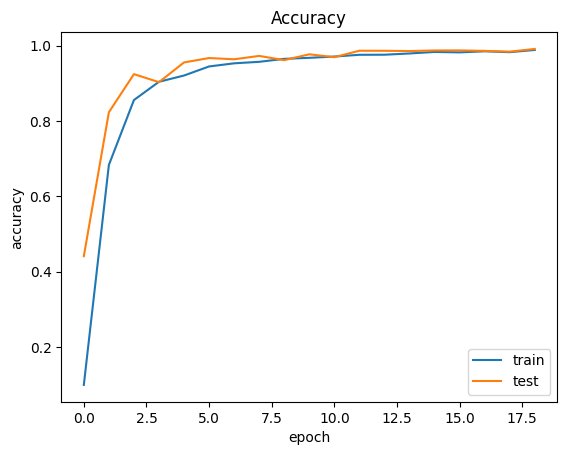

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [ ]:
#save model
model.save(filepath = "./TrainedModels/CustomDataset/CustomASLModel+99VA")
